In [285]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [286]:
transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=1),
#     transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])

train_data = datasets.CIFAR10(root = '../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root = '../Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [287]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [288]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [289]:
torch.manual_seed(0)

train_loader = DataLoader(train_data, batch_size=10, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False, pin_memory=True)

In [290]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

tensor([4, 3, 8, 1, 1, 7, 3, 7, 0, 2])

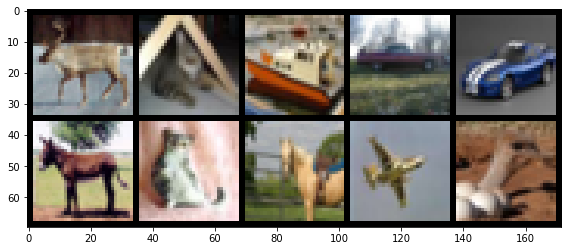

In [291]:
for images, labels in train_loader:
    break

im = make_grid(images, nrow=5)
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
labels

In [292]:
images.size()

torch.Size([10, 3, 32, 32])

In [293]:
class ConvModel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers1 = nn.Sequential(
            nn.Conv2d(3, 32, 3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128, 3,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.layers2 = nn.Sequential(
            nn.Dropout(p=.2, inplace=True),
            nn.Linear(4*4*128, 1024),
            nn.ReLU(inplace=True),
#             nn.Dropout(p=.2, inplace=True),
            nn.Linear(1024, 10)
        )
        
    def forward(self, X):
        X = self.layers1(X)
        X = torch.flatten(X, 1)
        X = self.layers2(X)
        X = F.log_softmax(X, dim=1)
        return X

In [294]:
torch.manual_seed(0)
model = ConvModel1()
model.cuda()
model

ConvModel1(
  (layers1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128

In [295]:
for item in model.parameters():
    print(item.numel())

864
32
32
32
9216
32
32
32
18432
64
64
64
36864
64
64
64
73728
128
128
128
147456
128
128
128
2097152
1024
10240
10


In [296]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [297]:
import time
start_time = time.time()
epochs = 50
train_losses = []
test_losses = []

train_correct = []
test_correct = []
best_accuracy = 0
early_stopping = 0

for e in range(epochs):
    epoch_time = time.time()
    trn_cor = 0
    tst_cor = 0
    model.train()
    for batch, (X_train, y_train) in enumerate(train_loader):
        
        X_train = X_train.cuda()
        y_train = y_train.cuda()
        
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_cor = (predicted==y_train).sum()
        trn_cor += batch_cor
    train_losses.append(loss)
    train_correct.append(trn_cor)
    
    model.eval()
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            
            X_test = X_test.cuda()
            y_test = y_test.cuda()
            
            y_val = model(X_test)
            predicted = torch.max(y_val.data,1)[1]
            
            batch_cor = (predicted==y_test).sum()
            tst_cor += batch_cor
            
        tst_loss = criterion(y_val, y_test)
        test_losses.append(tst_loss)
        test_correct.append(tst_cor)
    test_accuracy = tst_cor.item()*100/10000
    print(f'Epoch: {e+1} Loss: {loss.item():10.4f} Accuracy: {trn_cor.item()*100/50000:7.2f}% Val-loss: {tst_loss.item():10.4f} Val-accuracy: {test_accuracy:7.2f}% Epoch time: {time.time() - epoch_time}')
    
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_cnn.pt')
        best_accuracy = test_accuracy
        early_stopping = 0
        
    else:
        early_stopping +=1
    if early_stopping >= 10:
        print(f'Early stopping after {e+1} epochs')
        break
print(f'Duration of training: {(time.time() - start_time)/60:.2f} minutes.')

Epoch: 1 Loss:     0.9143 Accuracy:   56.12% Val-loss:     1.3647 Val-accuracy:   69.02% Epoch time: 104.00500202178955
Epoch: 2 Loss:     1.5519 Accuracy:   71.64% Val-loss:     1.0733 Val-accuracy:   74.37% Epoch time: 103.70033645629883
Epoch: 3 Loss:     0.7795 Accuracy:   77.07% Val-loss:     0.6351 Val-accuracy:   77.48% Epoch time: 103.79655051231384
Epoch: 4 Loss:     0.2910 Accuracy:   81.01% Val-loss:     0.7675 Val-accuracy:   80.05% Epoch time: 104.2309820652008
Epoch: 5 Loss:     0.6530 Accuracy:   84.15% Val-loss:     0.3705 Val-accuracy:   80.57% Epoch time: 103.88421964645386
Epoch: 6 Loss:     0.4518 Accuracy:   86.92% Val-loss:     0.2508 Val-accuracy:   81.10% Epoch time: 105.14915180206299
Epoch: 7 Loss:     0.2289 Accuracy:   88.86% Val-loss:     0.1247 Val-accuracy:   81.32% Epoch time: 104.30331182479858
Epoch: 8 Loss:     0.7424 Accuracy:   90.70% Val-loss:     0.5348 Val-accuracy:   81.30% Epoch time: 103.76044416427612
Epoch: 9 Loss:     0.5100 Accuracy:   92.

Text(0, 0.5, 'Crossentropy Loss')

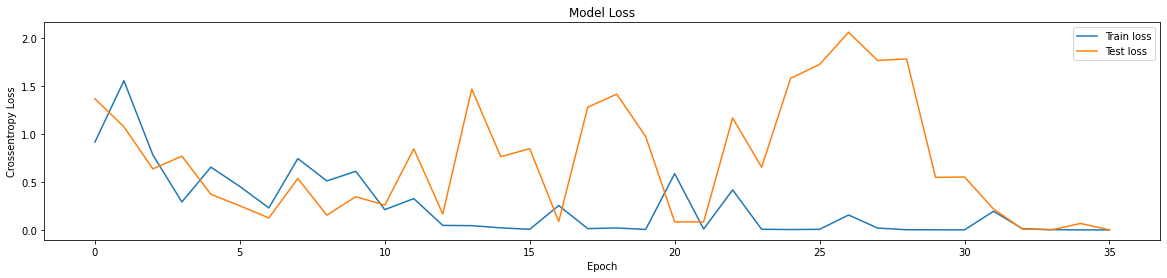

In [300]:
plt.figure(figsize=(20,4))
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Crossentropy Loss')

Text(0, 0.5, 'Accuracy')

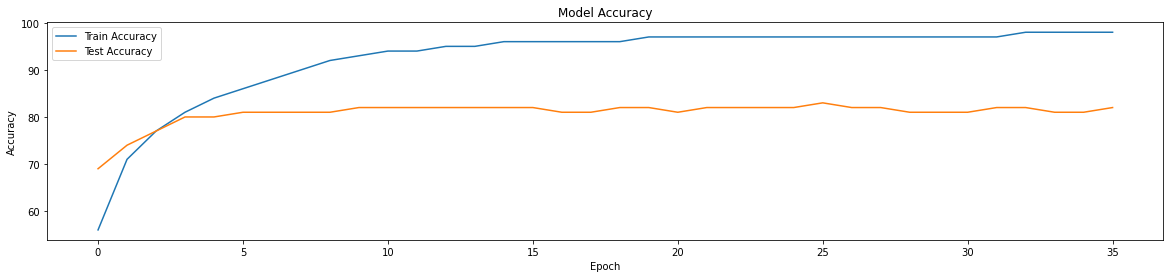

In [301]:
plt.figure(figsize=(20,4))
plt.plot([t*100/50000 for t in train_correct], label='Train Accuracy')
plt.plot([t*100/10000 for t in test_correct], label='Test Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')